# Import needed libraries

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns; sns.set()
import collections
from math import log
import matplotlib.pyplot as plt
plt.style.use('dark_background') # http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
from sklearn import linear_model
%matplotlib inline

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
#plt.rcParams['axes.facecolor'] = 'white' # uncomment if you want white background for plots

# Load the data files

In [2]:
student = pd.read_excel("./ORIGIN-GRADUATE_SCHOOL/dissertation_committees_2012-2017.xlsx")
faculty = pd.read_excel("./ORIGIN-SCHOLARSATDUKE/ScholarsAtDuke_Faculty_October2017.xlsx")
publications = pd.read_excel("./ORIGIN-SCHOLARSATDUKE/ScholarsAtDuke_Publications_2012-2017.xlsx")

# Study of Publications at Duke

In [3]:
# Get the principle appointment type of each faculty
#fac = faculty[faculty['APPOINTMENT_TYPE'] == "P"]
# Extract user ID and school name columns from "faculty" and put them together in df1 data frame.
df1 = faculty[['DUID','SCHOOL_NAME']] 
df1 = df1.drop_duplicates(subset='DUID', keep="first")

# Extract user ID, publication URI, and publication dates from "publications" and put them together in df2 data frame.
df_ = publications[['DUID','PUBLICATION_URI','PUBLICATION_DATE']] 
y = pd.to_datetime(df_['PUBLICATION_DATE']).dt.year

df2 = df_[(y > 2012) & (y < 2017)]
# Strip off the URLs from each publucation's identifier
df2['PUBLICATION_URI'] = df2['PUBLICATION_URI'].map(lambda x: x.lstrip('https://scholars.duke.edu/individual/'))
# Put df1 and df2 together in a new data frame called dfs
dfs = [df1, df2]
# Merge two data frames in dfs using the user ID column as referene. 
# The reduce function applies merge to df1 and df2. It's used when the merged data frames have more than two columns
# For more info see: https://stackoverflow.com/questions/23668427/pandas-joining-multiple-dataframes-on-columns

#df_final = reduce(lambda left,right: pd.merge(left,right,on='DUID'), dfs)


df_final = df2.merge(df1, left_on='DUID', right_on='DUID', how='left')

# Change the formatting of publication dates to YYYY-MM-DD and get the year using dt.year
years = pd.to_datetime(df_final['PUBLICATION_DATE']).dt.year
# Add a new column to df_final that has the years
df_final['YEAR'] = years
# First group everything in df_final by the school name and year of publication
# Then aggregate the publications using their URI, then get only the unique ones under each school's name
# Finally unstack them by school name
res = df_final.groupby(['SCHOOL_NAME','YEAR']).agg({'PUBLICATION_URI': pd.Series.nunique}).unstack('SCHOOL_NAME')
results = res['PUBLICATION_URI']

/Users/Varda/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Plot the total number of publications per year for each school

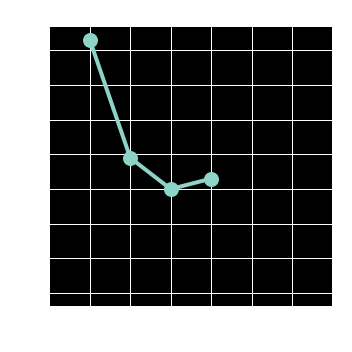

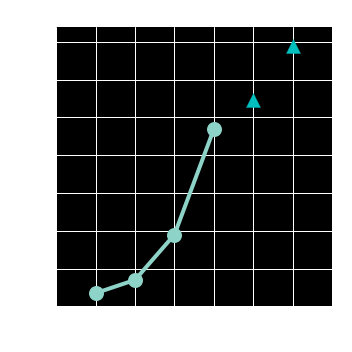

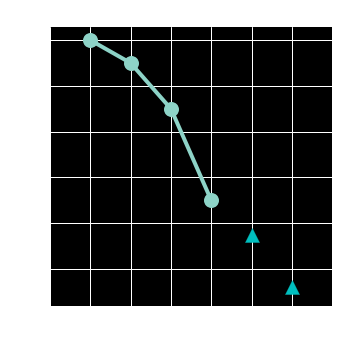

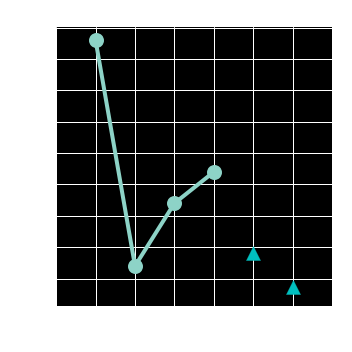

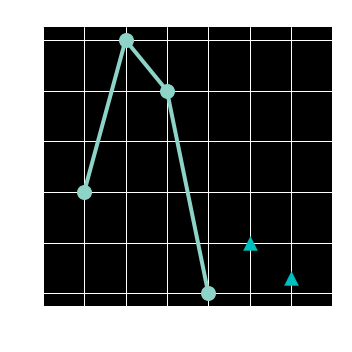

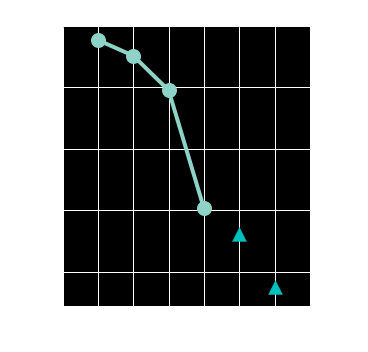

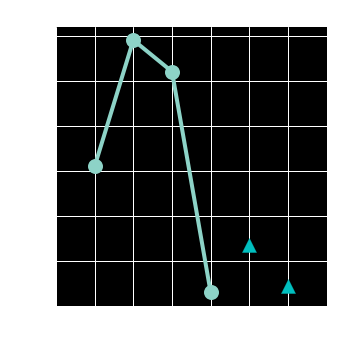

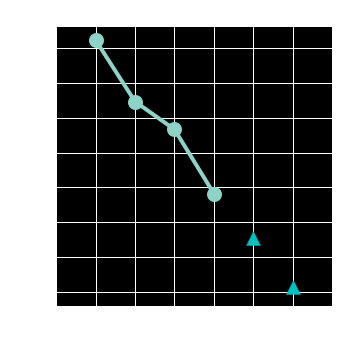

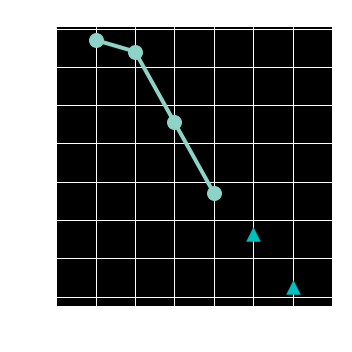

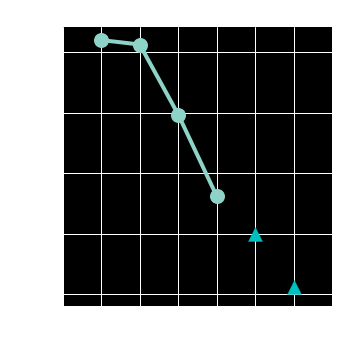

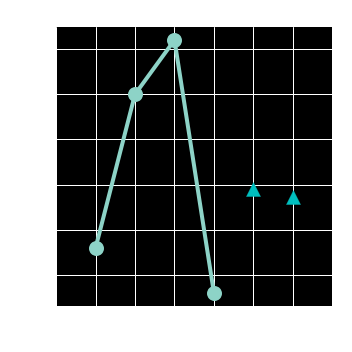

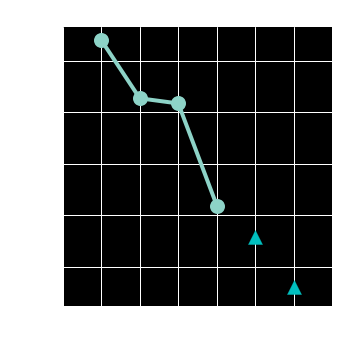

In [5]:
for col in results.columns:
    fig, ax =  plt.subplots(1,1,figsize = (5,5))
    ax = results[col].plot(title = col, marker = 'o', markersize = 15, lw = 4)

    
    if col == 'Divinity School':

        # Assume y = a*e^(b*X) and fit log(y) = log(a) + b*X for Divinity School
        X = np.array(results[col].index)[0:4]
        y = np.array(results[col].values)[0:4]
        b,a = np.polyfit(X, np.log(y), 1)
        prediction1 = a*np.exp(b*2017)
        prediction2 = a*np.exp(b*2018)
        ax.scatter(2017,prediction1, marker = '^', s = 0.1, c = 'c' )
        ax.scatter(2018,prediction2, marker = '^', s = 0.1, c = 'c')
    else:

        # Linear regression for other schools
        X = pd.DataFrame(results[col].index)[:4] # fitting to years 2012- 2016 only
        y = pd.DataFrame(results[col].values)[:4] # fitting to years 2012- 2016 only
        lm = linear_model.LinearRegression()
        model = lm.fit(X,y)
        prediction1 = lm.predict(2017)
        prediction2 = lm.predict(2018)
        ax.scatter(2017,prediction1, marker = '^', s = 200, c = 'c')
        ax.scatter(2018,prediction2, marker = '^', s = 200, c = 'c')
    

    ax.set_xlabel('Year',size = 18)
    ax.set_ylabel('Total Number of Publications', size = 18)
    ax.xaxis.set_ticks(np.arange(2012, 2020, 1))
    plt.tight_layout()
    plt.show()
    fig.savefig("publication_" + str(col) + ".png", dpi = 500, transparent=False) #Uncomment to save the figures 

### Plot the total number of publications per year at Duke

In [ ]:
# Total number of publications at Duke
df_tot = publications[['PUBLICATION_URI','PUBLICATION_DATE']] 
years = pd.to_datetime(df_tot['PUBLICATION_DATE']).dt.year
df_tot['YEAR'] = years
res = df_tot.groupby(['YEAR']).agg({'PUBLICATION_URI': pd.Series.nunique}).reset_index()
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(res['YEAR'], res['PUBLICATION_URI'], color = 'k', lw = 5,zorder=1)
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Study of Interdisciplinary Collaborations at Duke

In [13]:
# Get the principle appointment type of each faculty
#fp = faculty[faculty['APPOINTMENT_TYPE'] == "P"]
# Extract user ID and Organization name columns from "faculty" and put them together in df_org
df1 = faculty[['DUID','ORG_DISPLAY_NAME','SCHOOL_NAME']]
df2 = df1.drop_duplicates(subset='DUID', keep="first")

df_org = df2[['DUID','SCHOOL_NAME']] 
# Extract user ID, publication URI, and publication dates from "publications" and put them together in df_p
df_p = publications[['DUID','PUBLICATION_URI','PUBLICATION_DATE']] 
yy = pd.to_datetime(df_p['PUBLICATION_DATE']).dt.year
df_pub = df_p[(yy > 2012) & (yy < 2018)]
# Strip off the URLs from each publication's identifier
#df_pub['PUBLICATION_URI'] = df_pub['PUBLICATION_URI'].map(lambda x: x.lstrip('https://scholars.duke.edu/individual/'))
# Put df_org and df_pub together in a new data frame called df
df = [df_org, df_pub]
# Merge two data frames in df using the user ID column as referene. 
dff = reduce(lambda left,right: pd.merge(left,right,on='DUID'), df)
# Change the formatting of publication dates to YYYY-MM-DD and get the year using dt.year
yrs = pd.to_datetime(dff['PUBLICATION_DATE']).dt.year
# Add a new column to dff that has the years
dff['YEAR'] = yrs

### Plot the number of inter-departmental collaborations per year for each school

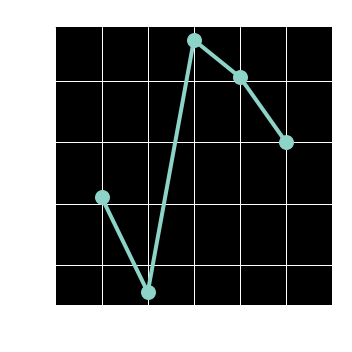

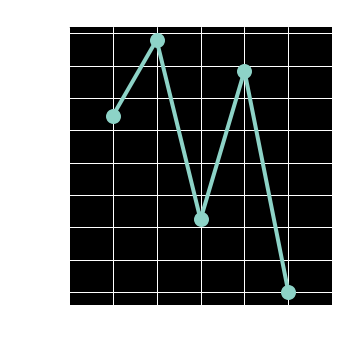

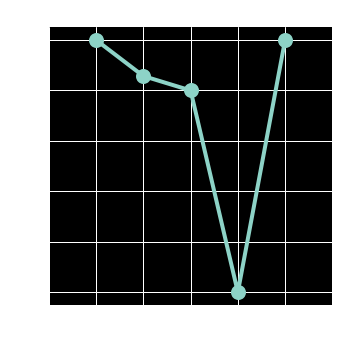

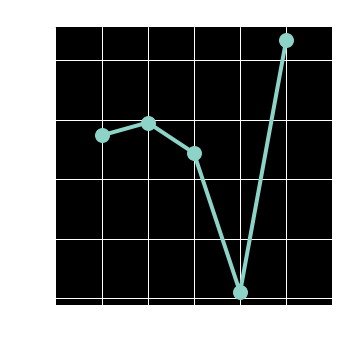

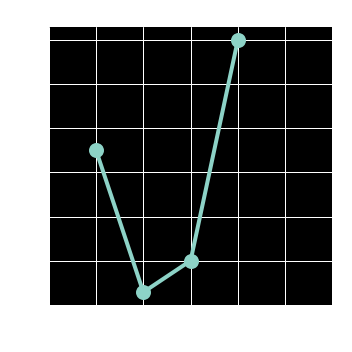

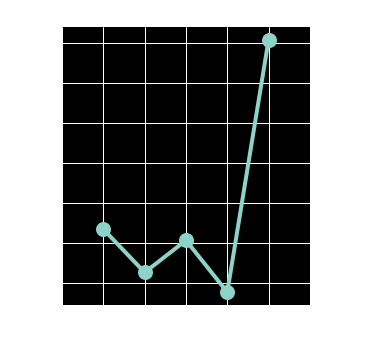

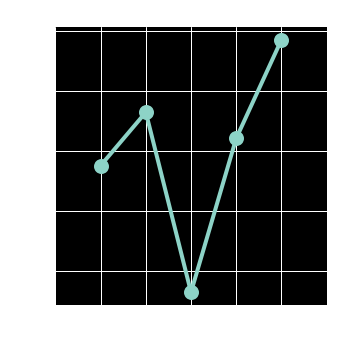

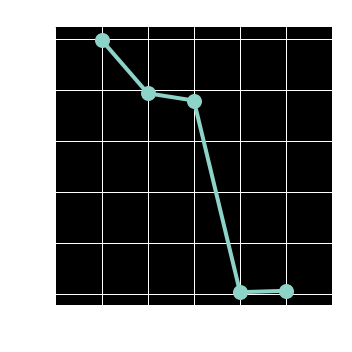

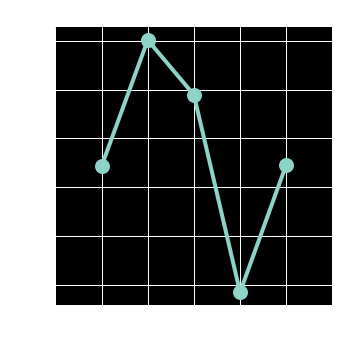

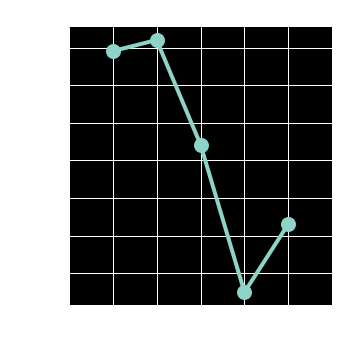

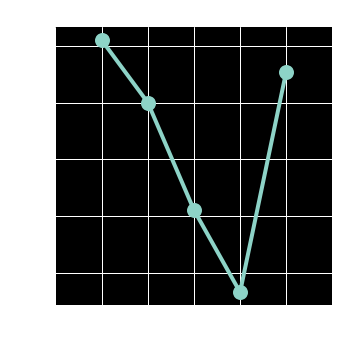

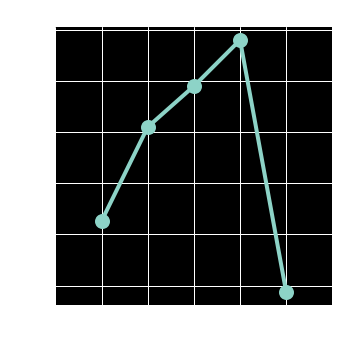

In [14]:
org_pub = pd.DataFrame(dff.groupby(['SCHOOL_NAME','YEAR'])['PUBLICATION_URI'].apply(set)).reset_index()
# Total number of publications per year for each school:
npub = pd.DataFrame([len(x) for x in org_pub['PUBLICATION_URI']])
cnt = len(org_pub)

# Find the number of collaborations inside each school:
# Calculate the frequency of each publication in a list of all publications and then count the number of  
# publications with frequencies greater than 1
pub_list= pd.DataFrame(dff.groupby(['SCHOOL_NAME','YEAR'])['PUBLICATION_URI'].apply(list)).reset_index()
collaborations_inside = []
ncol_inside = np.zeros(cnt)

for i in range(cnt):
    
    ls = np.array(pub_list['PUBLICATION_URI'][i])
    # The frequency
    freq = collections.Counter(ls)
    # Which ones are repeated more than once?
    multi = np.array((list(freq.values()))) > 1
    collaborations_inside.append( set(np.array(list(freq.keys()))[multi].flatten()))
    ncol_inside[i] = len(np.array(list(freq.keys()))[multi])

# Find the total number of collaborations for each school, by adding the outside collabs as well:
# Get the set of publications for each school and compare to other schools
ncol = np.zeros([cnt])
for j in range(cnt):
    collaborated = []
    for k in range(cnt):
        # inside
        if k == j:
            collaborated.append(collaborations_inside[j])
        else:
        # outside    
            collaborated.append(org_pub['PUBLICATION_URI'][j].intersection(org_pub['PUBLICATION_URI'][k]))  
            
    ncol[j] = len(set.union(*list(collaborated)))   
    
# Divide the number of collaboration by the total number of publication per year at each school    
org_pub['NCOL'] = pd.DataFrame(ncol.astype(int))/(npub)    

# Drop the 'PUBLICATION_URI' column
final = org_pub.drop(['PUBLICATION_URI'], axis=1)

# Group the data by school names and years and then get the NCOL column and set the numbers as float then unstack
r = pd.DataFrame(final.groupby(['SCHOOL_NAME','YEAR'])['NCOL'].apply(float)).unstack('SCHOOL_NAME')
rr = r['NCOL']

# The plotting
for col in rr.columns:
    fig, ax =  plt.subplots(1,1,figsize = (5,5))
    ax = rr[col].plot(title = col, marker = 'o', markersize = 15, lw = 4)
    ax.set_xlabel('Year',size = 20)
    ax.set_ylabel('% of collaborated publications')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.xaxis.set_ticks(np.arange(2012, 2019, 1))
    plt.tight_layout()
    plt.show()
    fig.savefig("collaboration_" + str(col) + ".png", dpi = 500, transparent=False) #Uncomment to save the figures 

### Total number of intere-departmental collaborations at Duke

In [ ]:
pub = dff.groupby(['SCHOOL_NAME','YEAR'])['PUBLICATION_URI'].apply(set).unstack('YEAR')
count = len(pub) 
all_collaborations = []
for col in pub.columns:
    coll_map = np.zeros([count,count])
    for i in range(count):
        for j in range(count):
            if i != j:
                coll_map[i,j] = len(pub[col][i].intersection(pub[col][j]))  
    all_collaborations.append([col,np.sum(coll_map)])

all_collaborations = np.array(all_collaborations)
fig,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(all_collaborations[:,0],all_collaborations[:,1],color = 'k', lw = 3,zorder=1)
ax.set_xlabel('Year',size = 20)
ax.set_ylabel('Interdisiplinary collaborations at Duke',size = 20)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_ticks(np.arange(2013, 2018, 1))
plt.show()

# Test cell, leave alone

In [ ]:
# Total number of publications per year for each school:
npub = pd.DataFrame([len(x) for x in org_pub['PUBLICATION_URI']])
cnt = len(org_pub)

# Find the number of collaborations inside each school:
# Calculate the frequency of each publication in a list of all publications and then count the number of publications 
# with frequencies greater than 1
pub_list= pd.DataFrame(dff.groupby(['SCHOOL_NAME','YEAR'])['PUBLICATION_URI'].apply(list)).reset_index()
ncol_inside = []
for i in range(cnt):
    ls = np.array(pub_list['PUBLICATION_URI'][i])
    ncol_inside.append((np.array(list(collections.Counter(ls).values())) > 1).sum())

# Find the number of outside collaborations for each school:
# Get the set of publications for each school and compare to other schools
ncol_outside = np.zeros([cnt])
for j in range(cnt):
    
    collaborated = []
    for k in range(cnt):
        if k != j:
            collaborated.append(org_pub['PUBLICATION_URI'][j].intersection(org_pub['PUBLICATION_URI'][k]))  
            
    ncol_outside[j] = len(reduce(set.union, list(collaborated)))

## Collaboration Heat Map and Cluster Map

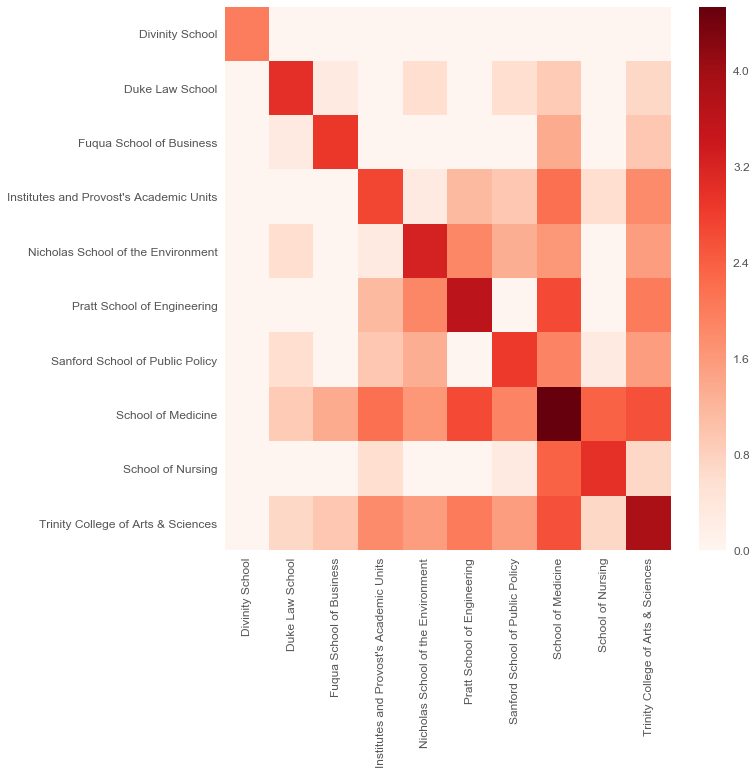

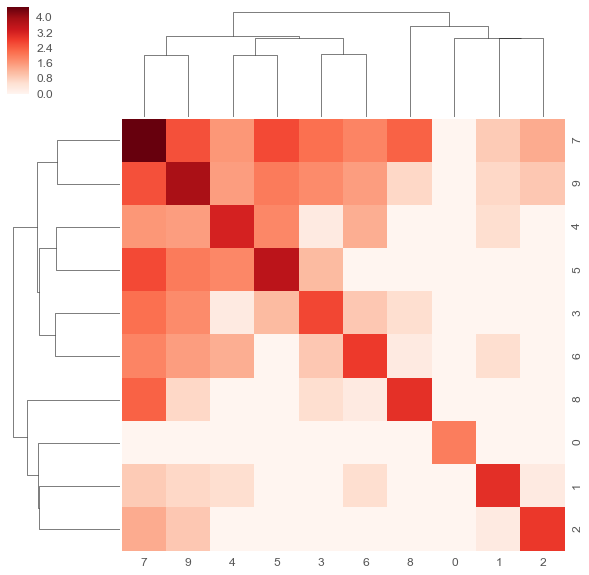

,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1048.0,2.0,1.0,4.0,0.0,4.0,8.0,0.0,5.0
2,0.0,2.0,777.0,0.0,0.0,1.0,0.0,23.0,1.0,9.0
3,0.0,1.0,0.0,501.0,2.0,14.0,9.0,153.0,4.0,64.0
4,0.0,4.0,0.0,2.0,1774.0,70.0,21.0,43.0,0.0,36.0
5,0.0,0.0,1.0,14.0,70.0,4351.0,0.0,461.0,0.0,109.0
6,0.0,4.0,0.0,9.0,21.0,0.0,742.0,79.0,2.0,35.0
7,0.0,8.0,23.0,153.0,43.0,461.0,79.0,34358.0,230.0,383.0
8,0.0,0.0,1.0,4.0,0.0,0.0,2.0,230.0,1016.0,5.0
9,0.0,5.0,9.0,64.0,36.0,109.0,35.0,383.0,5.0,7861.0


In [15]:
org_pub2 = pd.DataFrame(dff.groupby(['SCHOOL_NAME'])['PUBLICATION_URI'].apply(set)).reset_index()
# Get the name of each school, given their index
school_idx = dict(org_pub2['SCHOOL_NAME'].items())
# Now make the heat map matrix
count = len(org_pub2['PUBLICATION_URI'])
heatmap = np.zeros([count,count])
for i in range(count):
    for j in range(count):
        heatmap[i,j] = len(org_pub2['PUBLICATION_URI'][i].intersection(org_pub2['PUBLICATION_URI'][j]))        
# The logarithmic heatmap matrix
log_hm = np.zeros([count,count])
for i in range(count):
    for j in range(count):
        if heatmap[i,j] != 0:
            log_hm[i,j] = log(heatmap[i,j],10)
            
plt.figure(figsize = (10,10))
ax = sns.heatmap(log_hm,cmap="Reds")

# This part is for setting the right labels on each row and column
xticklabels = [] 
for i, item in enumerate(ax.get_xticklabels()): 
    item.set_text(school_idx[i]) 
    xticklabels += [item] 
    
yticklabels = [] 
for j, item in enumerate(ax.get_yticklabels()): 
    item.set_text(school_idx[j]) 
    yticklabels += [item] 
    
ax.set_xticklabels(xticklabels, rotation = 90) 
ax.set_yticklabels(yticklabels, rotation = 0)

# Cluster map
sns.clustermap(log_hm,cmap="Reds")
plt.show()
pd.DataFrame(heatmap)

# Collaboration Matrix for Gephi

In [39]:
org_pub3 = pd.DataFrame(dff.groupby(['ORG_DISPLAY_NAME'])['PUBLICATION_URI'].apply(set)).reset_index()
count = len(org_pub3['PUBLICATION_URI'])
school_idx = dict(org_pub3['ORG_DISPLAY_NAME'].items())
adjacency = np.zeros([count,count])
for i in range(count):
    for j in range(count):
        if j == i:
            adjacency[i,j] = 0
        else:
            adjacency[i,j] = len(org_pub3['PUBLICATION_URI'][i].intersection(org_pub3['PUBLICATION_URI'][j]))

log_adjacency = np.zeros([count,count])
for i in range(count):
    for j in range(count):
        if adjacency[i,j] != 0:
            log_adjacency[i,j] = log(adjacency[i,j],10)    
            
u = np.triu(log_adjacency)            
df = pd.DataFrame(u)
df.columns = school_idx.values()
df.index = school_idx.values()
#df.to_csv('schools_collaborations.csv',sep=';')